# Creating Custom Models

## Overview

This tutorial shows you how to create fully custom sequential sampling models in `ssm-simulators`.

You'll learn to:

- Define custom boundary functions
- Create custom drift functions
- Apply parameter sampling constraints
- Use theta processors for parameter preparation
- Register complete custom models

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# ssms imports
from ssms.config import ModelConfigBuilder
from ssms.config import (
    register_boundary,
    register_drift,
    register_model_config,
    get_boundary_registry,
    get_drift_registry,
    get_model_registry,
)
from ssms.basic_simulators import Simulator
import ssms.basic_simulators.boundary_functions as bf
import ssms.basic_simulators.drift_functions as df

## 1. Introduction - Levels of Customization

There are multiple levels at which you can customize models:

<div style="width: 100%; max-width: 650px; margin: 30px auto; padding: 0 20px; box-sizing: border-box;">
  <div style="width: 100%; padding: 20px; background-color: #e8f5e9; border: 3px solid #2e7d32; border-radius: 8px; margin-bottom: 20px; box-sizing: border-box;">
    <div style="font-weight: 700; font-size: 16px; margin-bottom: 10px; color: #1b5e20;">✅ Level 1: Use Built-in Boundaries & Drift</div>
    <div style="font-size: 13px; color: #555; line-height: 1.8;">
      Choose from existing boundary and drift functions<br/>
      <em>Easiest - covered in Tutorial 03</em>
    </div>
  </div>
  
  <div style="text-align: center; font-size: 24px; color: #666; margin: 10px 0;">↓</div>
  
  <div style="width: 100%; padding: 20px; background-color: #fff3e0; border: 3px solid #f57c00; border-radius: 8px; margin-bottom: 20px; box-sizing: border-box;">
    <div style="font-weight: 700; font-size: 16px; margin-bottom: 10px; color: #e65100;">🔧 Level 2: Define Custom Boundary/Drift Functions</div>
    <div style="font-size: 13px; color: #555; line-height: 1.8;">
      Create your own boundary or drift functions<br/>
      Register them in the system<br/>
      <em>Moderate - Section 2 & 3</em>
    </div>
  </div>
  
  <div style="text-align: center; font-size: 24px; color: #666; margin: 10px 0;">↓</div>
  
  <div style="width: 100%; padding: 20px; background-color: #e3f2fd; border: 3px solid #1976d2; border-radius: 8px; margin-bottom: 20px; box-sizing: border-box;">
    <div style="font-weight: 700; font-size: 16px; margin-bottom: 10px; color: #0d47a1;">🎯 Level 3: Add Parameter Transforms</div>
    <div style="font-size: 13px; color: #555; line-height: 1.8;">
      Define transforms directly in model config<br/>
      Sampling transforms (for training data) + Simulation transforms (for Simulator)<br/>
      <em>Moderate - Section 4 & 5</em>
    </div>
  </div>
  
  <div style="text-align: center; font-size: 24px; color: #666; margin: 10px 0;">↓</div>
  
  <div style="width: 100%; padding: 20px; background-color: #ffebee; border: 3px solid #c62828; border-radius: 8px; box-sizing: border-box;">
    <div style="font-weight: 700; font-size: 16px; margin-bottom: 10px; color: #b71c1c;">🚀 Level 4: Full Custom Model</div>
    <div style="font-size: 13px; color: #555; line-height: 1.8;">
      Combine all components<br/>
      Register complete custom model<br/>
      <em>Advanced - Section 6</em>
    </div>
  </div>
</div>

**This tutorial covers Levels 2-4.** Let's get started!

## 2. Custom Boundary Functions

### 2.1 Understanding Boundary Functions

Boundary functions define how decision thresholds behave over time. The signature is:

```python
def boundary_function(t, a, **params) -> float:
    """
    Args:
        t: Time (float or array)
        a: Threshold parameter (starting point)
        **params: Boundary-specific parameters
    
    Returns:
        Final boundary value at time t (including 'a')
    """
```

**Key points:**
- All boundary functions must accept `a` as a parameter
- The function should return the **final boundary value** (not just a modifier)
- Must handle both scalar and array `t` inputs
- Return values should be compatible with numpy operations

### 2.2 Creating a Custom Boundary

Let's create an exponential decay boundary: `boundary(t) = a * exp(-decay_rate * t) + offset`

This creates a boundary that starts at `a` and exponentially decays toward `offset`.

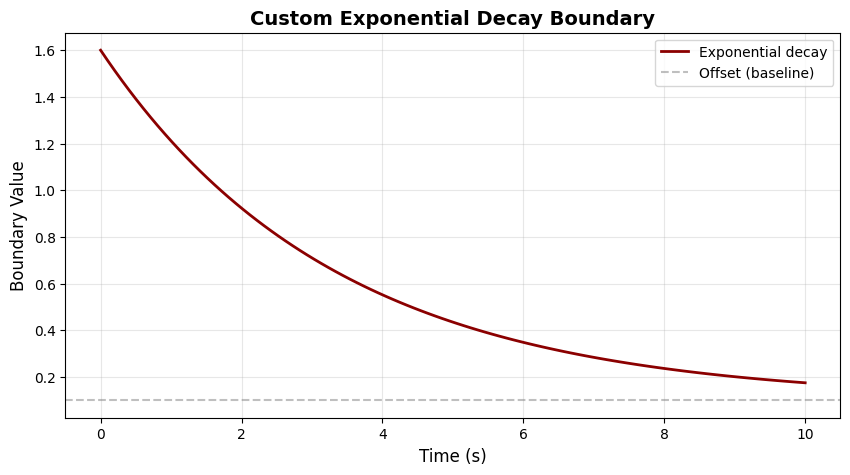

✓ Custom boundary function created and tested!


In [2]:
# Define a custom boundary function
def exponential_decay(t, a, decay_rate=0.1, offset=0.0):
    """Exponentially decaying boundary.
    
    Args:
        t: Time (float or array)
        a: Threshold parameter (starting point)
        decay_rate: Rate of exponential decay (higher = faster decay)
        offset: Minimum boundary value (baseline)
    
    Returns:
        Final boundary value at time t
    
    Example:
        At t=0: boundary = a + offset
        As t→∞: boundary → offset
    
    Note:
        numpy is imported locally so this function is self-contained when
        serialised by dill/pathos for multiprocessing workers.
    """
    import numpy as np
    return a * np.exp(-decay_rate * t) + offset

# Test the function
t_test = np.linspace(0, 10, 100)
a_test = 1.5  # Starting threshold
boundary_values = exponential_decay(t_test, a=a_test, decay_rate=0.3, offset=0.1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t_test, boundary_values, linewidth=2, color='darkred', label='Exponential decay')
plt.axhline(y=0.1, linestyle='--', color='gray', alpha=0.5, label='Offset (baseline)')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Boundary Value', fontsize=12)
plt.title('Custom Exponential Decay Boundary', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("✓ Custom boundary function created and tested!")

### 2.3 Registering the Boundary

Now that you've created your custom boundary function, you can register it at runtime using the registry system.

**No package editing required!** Just use `register_boundary()` to make your boundary available system-wide.

In [3]:
# Register the custom boundary - it's now available system-wide!
register_boundary(
    name="exponential_decay",
    function=exponential_decay,
    params=["a", "decay_rate", "offset"]  # 'a' must be listed as first param
)

print("✓ Custom boundary registered!")
print(f"  Name: 'exponential_decay'")
print(f"  Parameters: ['a', 'decay_rate', 'offset']")
print()

# Verify registration
registry = get_boundary_registry()
print(f"✓ Available boundaries ({len(registry.list_boundaries())} total):")
print(f"  {registry.list_boundaries()}")
print()
print("Your custom boundary can now be used with ModelConfigBuilder.add_boundary()!")

✓ Custom boundary registered!
  Name: 'exponential_decay'
  Parameters: ['a', 'decay_rate', 'offset']

✓ Available boundaries (6 total):
  ['angle', 'conflict_gamma', 'constant', 'exponential_decay', 'generalized_logistic', 'weibull_cdf']

Your custom boundary can now be used with ModelConfigBuilder.add_boundary()!


### 2.4 Using Your Custom Boundary

Once registered, you can use `ModelConfigBuilder` to add your boundary to models:

In [4]:
# Use your registered boundary with ModelConfigBuilder!
custom_model = ModelConfigBuilder.from_model("ddm")
custom_model = ModelConfigBuilder.add_boundary(
    custom_model,
    "exponential_decay",  # Using our custom registered boundary
)

print("✓ Created DDM with custom exponential decay boundary:")
print(f"  Boundary name: {custom_model.get('boundary_name')}")
print(f"  Boundary params: {custom_model.get('boundary_params')}")
print("The custom boundary works just like any built-in boundary!")

✓ Created DDM with custom exponential decay boundary:
  Boundary name: exponential_decay
  Boundary params: ['a', 'decay_rate', 'offset']
The custom boundary works just like any built-in boundary!


### 2.5 Testing Your Boundary

Always test your boundary by simulating and visualizing results:

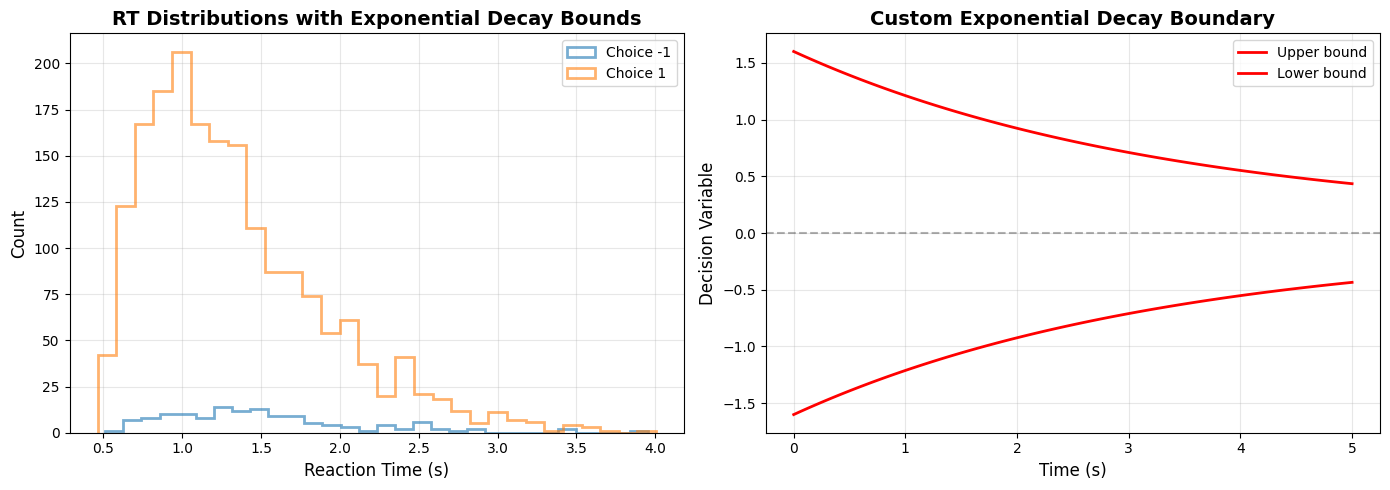


✓ Simulation successful with custom boundary!
Mean RT: 1.341s
Choice proportions: {np.int32(-1): np.int64(134), np.int32(1): np.int64(1866)}


In [5]:
# Simulate with the custom boundary model
sim = Simulator(model=custom_model)

# Simulate with custom boundary parameters
data = sim.simulate(
    theta={"v": 1.0, "a": 1.5, "z": 0.5, "t": 0.3, "decay_rate": 0.3, "offset": 0.1},
    n_samples=2000
)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RT histogram
for choice in [-1, 1]:
    mask = data['choices'] == choice
    rts = np.abs(data['rts'][mask])
    axes[0].hist(rts, bins=30, alpha=0.6, label=f'Choice {choice}', histtype='step', linewidth=2)

axes[0].set_xlabel('Reaction Time (s)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('RT Distributions with Exponential Decay Bounds', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Show the custom boundary over time
t_viz = np.linspace(0, 5, 100)
decay_rate_val = 0.3
offset_val = 0.1
a_param = 1.5
boundary_viz = exponential_decay(t_viz, a=a_param, decay_rate=decay_rate_val, offset=offset_val)

axes[1].plot(t_viz, boundary_viz, 'r-', linewidth=2, label='Upper bound')
axes[1].plot(t_viz, -boundary_viz, 'r-', linewidth=2, label='Lower bound')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].set_ylabel('Decision Variable', fontsize=12)
axes[1].set_title('Custom Exponential Decay Boundary', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Simulation successful with custom boundary!")
print(f"Mean RT: {np.mean(np.abs(data['rts'])):.3f}s")
print(f"Choice proportions: {dict(zip(*np.unique(data['choices'], return_counts=True)))}")

## 3. Custom Drift Functions

### 3.1 Understanding Drift Functions

Drift functions define how evidence accumulates over time. The signature is:

```python
def drift_function(t, v=0.0, **params) -> np.ndarray:
    """
    Args:
        t: Time array
        v: Base drift rate (optional - added to time-varying component)
        **params: Drift-specific parameters
    
    Returns:
        Final drift rate at each time point
    """
```

**Note:** Drift functions **can** include `v` as a parameter, mirroring how boundary functions can include `a`. When `v` is included, it typically serves as a base drift rate that the time-varying component is added to. Whether to include `v` depends on your model's needs - most built-in drift functions include it for consistency.

### 3.2 Creating a Custom Drift

Let's create a sinusoidal drift: `drift(t) = baseline + amplitude * sin(2π * frequency * t)`

This creates oscillating evidence accumulation, useful for modeling rhythmic processes.

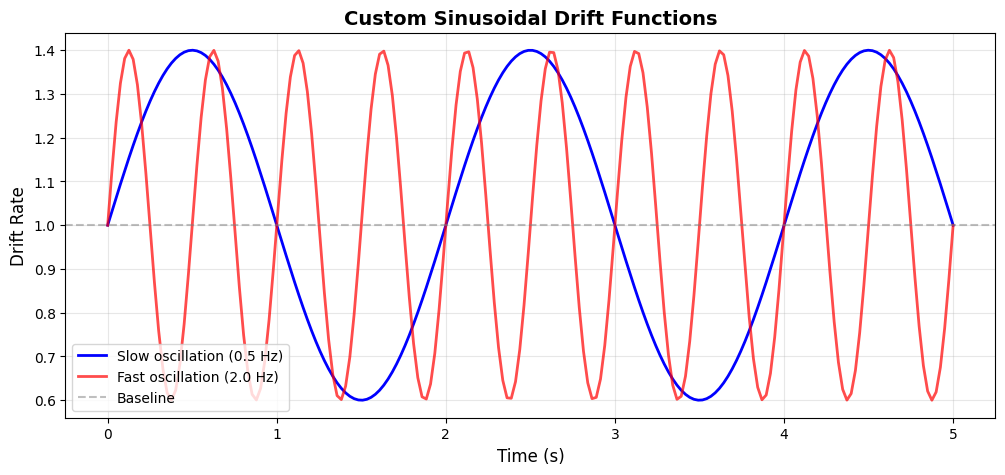

✓ Custom drift function created and tested!


In [6]:
# Define a custom drift function
def sinusoidal_drift(t, v=0.0, frequency=1.0, amplitude=0.5, baseline=1.0):
    """Sinusoidal drift rate.
    
    This drift function includes 'v' as a base drift parameter, following the
    convention of most built-in drift functions. Including 'v' is optional but
    provides consistency with the boundary function pattern (which use 'a').
    
    Args:
        t: Time array
        v: Base drift rate (optional - added to the sinusoidal component)
        frequency: Oscillation frequency (Hz)
        amplitude: Oscillation amplitude
        baseline: Baseline offset of the oscillation
    
    Returns:
        Final drift rate at each time point: v + baseline + amplitude * sin(...)
    
    Example:
        v=0, baseline=1.0, amplitude=0.5 creates drift oscillating between 0.5 and 1.5
    """
    return v + baseline + amplitude * np.sin(2 * np.pi * frequency * t)

# Test the function
t_test = np.linspace(0, 5, 200)
drift_slow = sinusoidal_drift(t_test, v=0.0, frequency=0.5, amplitude=0.4, baseline=1.0)
drift_fast = sinusoidal_drift(t_test, v=0.0, frequency=2.0, amplitude=0.4, baseline=1.0)

plt.figure(figsize=(12, 5))
plt.plot(t_test, drift_slow, linewidth=2, color='blue', label='Slow oscillation (0.5 Hz)')
plt.plot(t_test, drift_fast, linewidth=2, color='red', alpha=0.7, label='Fast oscillation (2.0 Hz)')
plt.axhline(y=1.0, linestyle='--', color='gray', alpha=0.5, label='Baseline')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Drift Rate', fontsize=12)
plt.title('Custom Sinusoidal Drift Functions', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("✓ Custom drift function created and tested!")

### 3.3 Registering the Drift

Just like boundaries, you can register your custom drift function at runtime.

**No package editing required!** Use `register_drift()` to make it available system-wide.

In [7]:
# Register the custom drift - it's now available system-wide!
# Note: Include 'v' in params if your drift function accepts it
register_drift(
    name="sinusoidal_drift",
    function=sinusoidal_drift,
    params=["v", "frequency", "amplitude", "baseline"]
)

print("✓ Custom drift registered!")
print(f"  Name: 'sinusoidal_drift'")
print(f"  Parameters: ['v', 'frequency', 'amplitude', 'baseline']")
print()

# Verify registration
drift_registry = get_drift_registry()
print(f"✓ Available drifts ({len(drift_registry.list_drifts())} total):")
print(f"  {drift_registry.list_drifts()}")
print()
print("Your custom drift can now be used with ModelConfigBuilder.add_drift()!")

✓ Custom drift registered!
  Name: 'sinusoidal_drift'
  Parameters: ['v', 'frequency', 'amplitude', 'baseline']

✓ Available drifts (10 total):
  ['attend_drift', 'attend_drift_simple', 'conflict_ds_drift', 'conflict_dsstimflex_drift', 'conflict_stimflex_drift', 'conflict_stimflexrel1_drift', 'conflict_stimflexrel1_dual_drift', 'constant', 'gamma_drift', 'sinusoidal_drift']

Your custom drift can now be used with ModelConfigBuilder.add_drift()!


### 3.4 Using Your Custom Drift

Add custom drift to models using `ModelConfigBuilder`:

In [8]:
# Use your registered drift with ModelConfigBuilder!
custom_drift_model = ModelConfigBuilder.from_model("ddm")
custom_drift_model = ModelConfigBuilder.add_drift(
    custom_drift_model,
    "sinusoidal_drift",  # Using our custom registered drift
)

print("✓ Created DDM with custom sinusoidal drift:")
print(f"  Drift name: {custom_drift_model.get('drift_name')}")
print(f"  Drift params: {custom_drift_model.get('drift_params')}")
print()
print("The custom drift works just like any built-in drift!")

✓ Created DDM with custom sinusoidal drift:
  Drift name: sinusoidal_drift
  Drift params: ['v', 'frequency', 'amplitude', 'baseline']

The custom drift works just like any built-in drift!


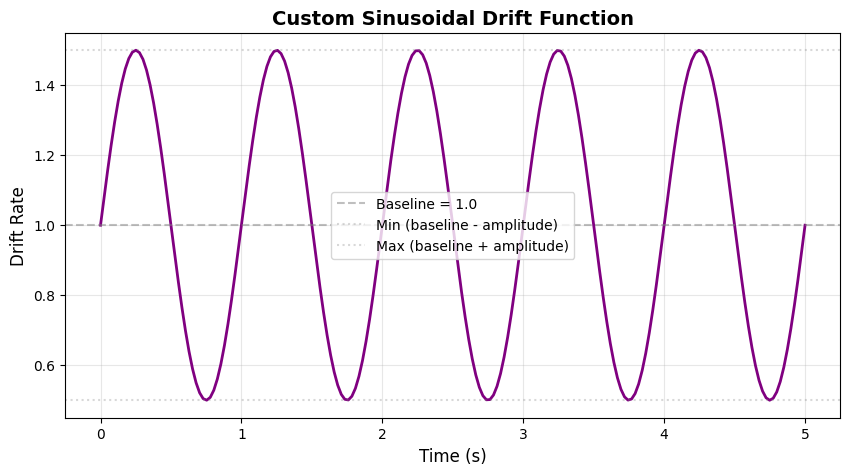

✓ Drift oscillates between [0.50, 1.50]


In [9]:
# Visualize the custom sinusoidal drift over time
t_viz = np.linspace(0, 5, 200)
drift_values = sinusoidal_drift(t_viz, frequency=1.0, amplitude=0.5, baseline=1.0)

plt.figure(figsize=(10, 5))
plt.plot(t_viz, drift_values, linewidth=2, color='purple')
plt.axhline(y=1.0, linestyle='--', color='gray', alpha=0.5, label='Baseline = 1.0')
plt.axhline(y=0.5, linestyle=':', color='gray', alpha=0.3, label='Min (baseline - amplitude)')
plt.axhline(y=1.5, linestyle=':', color='gray', alpha=0.3, label='Max (baseline + amplitude)')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Drift Rate', fontsize=12)
plt.title('Custom Sinusoidal Drift Function', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"✓ Drift oscillates between [{drift_values.min():.2f}, {drift_values.max():.2f}]")

## 4. Parameter Transforms

### 4.1 The Unified `parameter_transforms` Pattern

Parameter transforms are specified in a unified format within your model configuration:

```python
"parameter_transforms": {
    "sampling": [...],   # Applied during parameter sampling (training data generation)
    "simulation": [...], # Applied during simulation (Simulator class)
}
```

**Two types of transforms:**

| Transform Type | When Applied | Purpose | Example Use Case |
|---------------|--------------|---------|------------------|
| **Sampling** | During parameter sampling (training data generation workflow) | Enforce parameter constraints after sampling | Ensure `a > z`, normalize drift rates |
| **Simulation** | When running simulations via `Simulator` | Prepare parameters for low-level Cython simulators | Stack `v0, v1, v2` → `v` array, expand dimensions |

**Key insight:** Both transform types are defined together in the model config, making it easy to see all parameter handling logic in one place.

*Simulation transforms* are the link between our `model_config` and the low-level Cython simulators. They allow us to reuse simulators across multiple model configs. If you provide a custom simulation function, you may not need simulation transforms—but check if you can reuse existing simulators first!

### 4.2 Built-in Sampling Transforms

The package includes two built-in sampling transforms:

In [10]:
# Demonstrate built-in sampling transforms
from ssms.transforms import SwapIfLessConstraint, NormalizeToSumConstraint

# Example 1: Swap constraint (enforces a > z)
print("Example 1: Swap Constraint")
print("=" * 60)
theta_before = {"v": 1.0, "a": 0.5, "z": 0.7, "t": 0.3}
print(f"Before swap: a={theta_before['a']}, z={theta_before['z']}")

swap_constraint = SwapIfLessConstraint(param_a="a", param_b="z")
theta_after = swap_constraint.apply(theta_before.copy())
print(f"After swap:  a={theta_after['a']}, z={theta_after['z']}")
print(f"✓ Constraint a > z is now satisfied!")

# Example 2: Normalize constraint
print("\n\nExample 2: Normalize Constraint")
print("=" * 60)
theta_drift = {"v1": 0.3, "v2": 0.5, "v3": 0.1}
print(f"Before normalize: {theta_drift}")
print(f"Sum: {sum(theta_drift.values()):.3f}")

normalize_constraint = NormalizeToSumConstraint(param_names=["v1", "v2", "v3"])
theta_normalized = normalize_constraint.apply(theta_drift.copy())
print(f"\nAfter normalize: {theta_normalized}")
print(f"Sum: {sum(theta_normalized.values()):.3f}")
print(f"✓ Drift rates now sum to 1.0!")

Example 1: Swap Constraint
Before swap: a=0.5, z=0.7
After swap:  a=0.7, z=0.5
✓ Constraint a > z is now satisfied!


Example 2: Normalize Constraint
Before normalize: {'v1': 0.3, 'v2': 0.5, 'v3': 0.1}
Sum: 0.900

After normalize: {'v1': 0.3333333333333333, 'v2': 0.5555555555555556, 'v3': 0.11111111111111112}
Sum: 1.000
✓ Drift rates now sum to 1.0!


### 4.3 Creating Custom Sampling Transforms

Custom transforms are simply Python objects with an `apply` method. No registration needed!

In [11]:
# Example: Exponential transform for drift rate (using LambdaAdaptation)
from ssms.transforms import LambdaAdaptation

# Create a transform using LambdaAdaptation for simple cases
exp_v_transform = LambdaAdaptation(
    lambda theta, cfg, n: (
        theta.update({"v": np.exp(theta["v"])}) if "v" in theta else None
    ) or theta,
    name="exp_v"
)

print("✓ Created custom transform using LambdaAdaptation")

# Test it
test_theta = {"v": -0.5, "a": 1.5, "z": 0.5, "t": 0.3}
print(f"\nBefore exp transform: v = {test_theta['v']:.3f}")
result_theta = exp_v_transform.apply(test_theta.copy(), {}, 1)
print(f"After exp transform:  v = {result_theta['v']:.3f}")

✓ Created custom transform using LambdaAdaptation

Before exp transform: v = -0.500
After exp transform:  v = 0.607


### 4.4 Creating Custom Transforms - Class-Based

For reusable transforms with configurable parameters, create a class:

In [12]:
# Example: Scale transform with configurable factor
from ssms.transforms.base import ParameterTransform

class ScaleTransform(ParameterTransform):
    """Scale a parameter by a factor."""
    
    def __init__(self, param_name: str, factor: float = 1.0):
        self.param_name = param_name
        self.factor = factor
    
    def apply(self, theta: dict, model_config=None, n_trials=None) -> dict:
        if self.param_name in theta:
            theta[self.param_name] *= self.factor
        return theta

print("✓ Created custom class-based transform 'ScaleTransform'")

# Test it - just instantiate and use directly
test_theta = {"v": 1.0, "a": 1.5, "z": 0.5, "t": 0.3}
print(f"\nBefore scale: a = {test_theta['a']:.3f}")

scale_transform = ScaleTransform(param_name="a", factor=2.0)
result_theta = scale_transform.apply(test_theta.copy())
print(f"After scale (factor=2.0): a = {result_theta['a']:.3f}")

# Then use it in model config:
# "parameter_transforms": {"sampling": [ScaleTransform("a", 2.0)], ...}

✓ Created custom class-based transform 'ScaleTransform'

Before scale: a = 1.500
After scale (factor=2.0): a = 3.000


### 4.5 Using Transforms in model_config

Add transforms directly to your model configuration using the unified `parameter_transforms` field:

In [13]:
# Create a model config with custom parameter transforms
from ssms.transforms import SwapIfLessConstraint, LambdaAdaptation
import numpy as np

# Use the ScaleTransform we defined earlier (or define inline)
my_model_with_transforms = {
    "name": "ddm_with_transforms",
    "params": ["v", "a", "z", "t"],
    "param_bounds_dict": {
        "v": (-3.0, 3.0),  # Will sample symmetric range
        "a": (0.5, 2.5),
        "z": (0.1, 0.9),
        "t": (0.0, 2.0),
    },
    "parameter_transforms": {
        "sampling": [
            # Scale 'a' by 1.5 using our custom transform
            ScaleTransform("a", factor=1.5),
            
            # Ensure a > z using built-in
            SwapIfLessConstraint("a", "z"),
        ],
        "simulation": [],
    },
    "nchoices": 2,
}

print("Model config with parameter transforms:")
print("=" * 60)
print("\nSampling transforms:")
for i, t in enumerate(my_model_with_transforms["parameter_transforms"]["sampling"], 1):
    print(f"  {i}. {t}")

print("\n✓ Transforms are Python objects - no registration needed!")
print("✓ Transforms will be applied in order during data generation")
print("Order matters! Transforms are applied sequentially.")

Model config with parameter transforms:

Sampling transforms:
  1. ScaleTransform(param_name='a', factor=1.5)
  2. SwapIfLessConstraint(param_a='a', param_b='z')

✓ Transforms are Python objects - no registration needed!
✓ Transforms will be applied in order during data generation
Order matters! Transforms are applied sequentially.


### 4.6 Transform Execution Order

**Important:** Transforms are applied in the order specified!

Example sequence for sampling transforms:
1. Sample `a` from [0.5, 2.5] → might get `a = 0.6`
2. Apply `ScaleParameter("a", 1.5)` → `a = 0.9`
3. Sample `z` from [0.1, 0.9] → might get `z = 0.95`
4. Apply `SwapIfLessConstraint("a", "z")` → ensures `a > z` by swapping if needed

This allows complex parameter preparation pipelines while keeping all logic co-located in the model config.

## 5. Simulation Transforms (Parameter Adapters)

### 5.1 What Are Simulation Transforms?

Simulation transforms prepare parameters **when running the Simulator** to:
- Handle array dimensions (e.g., expand `(n,)` → `(n, 1)`)
- Provide default values for fixed parameters
- Rename parameters to match simulator signatures
- Combine multiple parameters (e.g., stack `v0, v1, v2` → `v`)

**Defined in the same `parameter_transforms` field:**

```python
"parameter_transforms": {
    "sampling": [...],   # For training data generation
    "simulation": [      # For Simulator class
        ColumnStackParameters(["v0", "v1", "v2"], "v"),
        ExpandDimension(["a", "z"]),
        SetZeroArray("t"),
    ],
}
```

**Key insight:** Simulation transforms are ubiquitously applied across models because they enable **simulator reuse**. The same low-level Cython simulator can serve many model variants by using different simulation transforms.

Most custom models will need simulation transforms. Sampling transforms are rarer—only needed when parameter constraints can't be expressed via bounds alone.



### 5.2 Built-in Simulation Transforms

The package provides several built-in simulation transforms:

In [14]:
# Import parameter adaptation classes
from ssms.basic_simulators.parameter_adapters import (
    ParameterAdaptation,
    SetDefaultValue,
    ExpandDimension,
    RenameParameter,
    DeleteParameters,
)

# Example 1: SetDefaultValue
print("Example 1: SetDefaultValue")
print("=" * 60)
theta = {"v": 1.0, "a": 1.5}  # Missing 'z' and 't'
transform1 = SetDefaultValue("z", 0.5)
transform2 = SetDefaultValue("t", 0.3)

theta = transform1.apply(theta, {}, n_trials=100)
theta = transform2.apply(theta, {}, n_trials=100)
print(f"After adding defaults: {theta}")

# Example 2: ExpandDimension
print("\n\nExample 2: ExpandDimension")
print("=" * 60)
# ExpandDimension expects array inputs, so convert scalars to arrays first
theta = {
    "v": np.array([1.0]),  # 1D array
    "a": np.array([1.5]),  # 1D array
    "z": 0.5,
    "t": 0.3
}
expand = ExpandDimension(["v", "a"])

print(f"Before expand: v shape = {theta['v'].shape}")
theta_expanded = expand.apply(theta.copy(), {}, n_trials=100)
print(f"After expand:  v shape = {theta_expanded['v'].shape}")
print(f"               a shape = {theta_expanded['a'].shape}")
print(f"\nNote: ExpandDimension adds a dimension for trial-by-trial variation")

Example 1: SetDefaultValue
After adding defaults: {'v': 1.0, 'a': 1.5, 'z': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], dtype=float32), 't': array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0

### 5.3 Creating Custom Simulation Transforms

Create custom simulation transforms by subclassing `ParameterAdaptation`:

In [15]:
# Custom transformation: Normalize velocities to unit vector
class NormalizeVelocities(ParameterAdaptation):
    """Normalize drift parameters to unit length."""
    
    def __init__(self, param_names: list):
        self.param_names = param_names
    
    def apply(self, theta: dict, model_config: dict, n_trials: int) -> dict:
        """Normalize specified parameters to unit length."""
        # Extract params
        values = [theta[p] for p in self.param_names]
        
        # Compute norm
        norm = np.sqrt(sum(v**2 for v in values))
        
        # Normalize and update
        for p, v in zip(self.param_names, values):
            theta[p] = v / norm
        
        return theta

# Test it
theta_test = {"v1": 3.0, "v2": 4.0, "other": 1.0}
print("Before normalization:")
print(f"  v1 = {theta_test['v1']}, v2 = {theta_test['v2']}")
print(f"  Norm = {np.sqrt(theta_test['v1']**2 + theta_test['v2']**2):.3f}")

normalizer = NormalizeVelocities(["v1", "v2"])
theta_normalized = normalizer.apply(theta_test.copy(), {}, n_trials=100)

print("\nAfter normalization:")
print(f"  v1 = {theta_normalized['v1']:.3f}, v2 = {theta_normalized['v2']:.3f}")
print(f"  Norm = {np.sqrt(theta_normalized['v1']**2 + theta_normalized['v2']**2):.3f}")
print(f"  ✓ Parameters normalized to unit vector!")

Before normalization:
  v1 = 3.0, v2 = 4.0
  Norm = 5.000

After normalization:
  v1 = 0.600, v2 = 0.800
  Norm = 1.000
  ✓ Parameters normalized to unit vector!


### 5.4 Adding Simulation Transforms to Your Model

Add simulation transforms directly to your model configuration—no separate registration needed:

In [16]:
# Define simulation transforms directly in your model config
from ssms.basic_simulators.parameter_adapters import (
    SetDefaultValue,
    ExpandDimension,
    ColumnStackParameters,
    SetZeroArray,
)

# Example: A 3-choice race model needs these transforms
my_race_model_config = {
    "name": "my_race_3",
    "params": ["v0", "v1", "v2", "a", "z", "t"],
    "param_bounds_dict": {
        "v0": (0.0, 3.0), "v1": (0.0, 3.0), "v2": (0.0, 3.0),
        "a": (0.5, 2.5), "z": (0.1, 0.9), "t": (0.0, 1.0),
    },
    "nchoices": 3,
    # All transforms defined together in the config
    "parameter_transforms": {
        "sampling": [],  # No sampling constraints needed
        "simulation": [
            # Stack individual drift rates into array
            ColumnStackParameters(["v0", "v1", "v2"], "v", delete_sources=False),
            # Expand scalar params to match array shapes
            ExpandDimension(["a", "z", "t"]),
        ],
    },
}

print("✓ Model config with simulation transforms defined inline:")
print(f"\nSimulation transforms pipeline:")
for i, t in enumerate(my_race_model_config["parameter_transforms"]["simulation"], 1):
    print(f"  {i}. {t}")
print()
print("No separate registration needed!")
print("Transforms are applied automatically when using Simulator with this config.")

✓ Model config with simulation transforms defined inline:

Simulation transforms pipeline:
  1. ColumnStackParameters(source_params=['v0', 'v1', 'v2'], target_param='v', delete_sources=False)
  2. ExpandDimension(param_names=['a', 'z', 't'])

No separate registration needed!
Transforms are applied automatically when using Simulator with this config.


## 6. Full Model Registration

### 6.1 Bringing It All Together

Let's create a complete custom model by combining all the pieces:

In [17]:
# Create a complete custom model configuration with our exponential_decay boundary
# We'll use ddm_flexbound which accepts custom boundary functions
from ssms.transforms import SwapIfLessConstraint

full_custom_model = {
    "name": "custom_ddm_demo",
    "params": ["v", "a", "z", "t", "decay_rate", "offset"],
    "param_bounds_dict": {
        "v": (-3.0, 3.0),          # Drift rate
        "a": (0.8, 2.5),           # Boundary separation
        "z": (0.3, 0.7),           # Starting point
        "t": (0.1, 0.5),           # Non-decision time
        "decay_rate": (0.05, 0.5), # Exponential decay rate for boundary
        "offset": (0.0, 0.3),      # Baseline offset for boundary
    },
    "nchoices": 2,
    "n_params": 6,
    "default_params": [1.0, 1.5, 0.5, 0.3, 0.1, 0.1],
}

# Add parameter transforms using the unified format
full_custom_model["parameter_transforms"] = {
    "sampling": [
        # Ensure a > z
        SwapIfLessConstraint("a", "z"),
    ],
    "simulation": [],
}

print("Complete Custom Model Configuration:")
print("=" * 60)
print(f"Name: {full_custom_model['name']}")
print(f"Parameters: {full_custom_model['params']}")
print(f"\nParameter bounds:")
for param, bounds in full_custom_model['param_bounds_dict'].items():
    print(f"  {param}: {bounds}")
print(f"\nTransforms: {len(full_custom_model['parameter_transforms']['sampling'])} sampling, "
      f"{len(full_custom_model['parameter_transforms']['simulation'])} simulation")
print("\n✓ This model uses our custom exponential_decay boundary function!")

Complete Custom Model Configuration:
Name: custom_ddm_demo
Parameters: ['v', 'a', 'z', 't', 'decay_rate', 'offset']

Parameter bounds:
  v: (-3.0, 3.0)
  a: (0.8, 2.5)
  z: (0.3, 0.7)
  t: (0.1, 0.5)
  decay_rate: (0.05, 0.5)
  offset: (0.0, 0.3)

Transforms: 1 sampling, 0 simulation

✓ This model uses our custom exponential_decay boundary function!


### 6.2 Validating Your Model

Always validate your configuration before using it:

In [18]:
# Validate the model configuration
is_valid, errors = ModelConfigBuilder.validate_config(full_custom_model, strict=False)

print("Validation Results:")
print("=" * 60)
if is_valid:
    print("✓ Configuration is valid!")
else:
    print("⚠ Configuration has warnings:")
    for error in errors:
        print(f"  - {error}")
    print("\nNote: For this tutorial demo, missing 'simulator' is expected.")
    print("In production, you'd register the actual simulator function.")

# Additional checks
print("\n" + "=" * 60)
print("Configuration Structure Check:")
print(f"  ✓ Has {len(full_custom_model['params'])} parameters")
print(f"  ✓ All parameters have bounds defined")
print(f"  ✓ Parameter sampling constraints registered")
print("\n✓ Config structure is correct (missing simulator is OK for this demo)!")

Validation Results:
⚠ Configuration has warnings:
  - Missing required field: 'simulator'

Note: For this tutorial demo, missing 'simulator' is expected.
In production, you'd register the actual simulator function.

Configuration Structure Check:
  ✓ Has 6 parameters
  ✓ All parameters have bounds defined
  ✓ Parameter sampling constraints registered

✓ Config structure is correct (missing simulator is OK for this demo)!


### 6.3 Using Your Custom Model

Once validated, you can use your custom model for simulation and data generation. Let's make it fully functional by adding the necessary simulator components:

In [19]:
# Now let's actually use our custom model with the flexible boundary simulator!
# This simulator accepts custom boundary functions
from cssm.ddm_models import ddm_flexbound

# Configure to use our exponential_decay boundary
full_custom_model["simulator"] = ddm_flexbound
full_custom_model["boundary"] = exponential_decay  # Our custom boundary!
full_custom_model["boundary_name"] = "exponential_decay"
full_custom_model["boundary_params"] = ["a", "decay_rate", "offset"]
full_custom_model["choices"] = [-1, 1]
full_custom_model["n_particles"] = 1

# Re-register the model now that it's fully configured
register_model_config("custom_ddm_demo", full_custom_model)
print("✓ Configured and registered model to use ddm_flexbound with exponential_decay boundary!")
print("  Model can now be looked up by name: 'custom_ddm_demo'")

# 1. Simulate from the model
print("1. Running simulation with custom model:")
print("=" * 60)
sim = Simulator(model=full_custom_model)
data = sim.simulate(
    theta={
        "v": 1.0,
        "a": 1.5,
        "z": 0.5,
        "t": 0.3,
        "decay_rate": 0.2,  # Exponential decay rate for boundary
        "offset": 0.1       # Boundary offset
    },
    n_samples=1000
)
print(f"✓ Generated {len(data['rts'])} samples")
print(f"  Mean RT: {np.mean(data['rts']):.3f}")
print(f"  Choice proportions: {np.unique(data['choices'], return_counts=True)}")

# 2. Generate training data
print("\n2. Generating training data:")
print("=" * 60)
from ssms.dataset_generators.lan_mlp import TrainingDataGenerator
from ssms.config.generator_config.data_generator_config import get_default_generator_config

config = get_default_generator_config("lan")
config['pipeline']['n_parameter_sets'] = 2
config['pipeline']['n_subruns'] = 1
config['training']['n_samples_per_param'] = 100

gen = TrainingDataGenerator(config=config, model_config=full_custom_model)
training_data = gen.generate_data_training(save=False)

print(f"✓ Generated training data:")
print(f"  LAN data shape: {training_data['lan_data'].shape}")
print(f"  LAN labels shape: {training_data['lan_labels'].shape}")
print(f"  Theta shape: {training_data['theta'].shape}")
print("\n✓ Your custom model is fully functional!")

✓ Configured and registered model to use ddm_flexbound with exponential_decay boundary!
  Model can now be looked up by name: 'custom_ddm_demo'
1. Running simulation with custom model:
✓ Generated 1000 samples
  Mean RT: 1.464
  Choice proportions: (array([-1,  1], dtype=int32), array([ 65, 935]))

2. Generating training data:
✓ Generated training data:
  LAN data shape: (200, 8)
  LAN labels shape: (200,)
  Theta shape: (2, 6)

✓ Your custom model is fully functional!


### 6.4 Registering Complete Custom Models

You can also register your entire custom model configuration to make it reusable:

In [20]:
# Verify that our model was registered in the previous cell
model_registry = get_model_registry()
print("✓ Model 'custom_ddm_demo' is now available in the registry")
print(f"  Total registered models: {len(model_registry.list_models())}")

# Now you can retrieve it by name using ModelConfigBuilder!
retrieved_model = ModelConfigBuilder.from_model("custom_ddm_demo")
print("\n✓ Retrieved model from registry using ModelConfigBuilder.from_model():")
print(f"  Name: {retrieved_model.get('name')}")
print(f"  Params: {retrieved_model.get('params')}")
print(f"  Boundary: {retrieved_model.get('boundary_name')}")

# Or use it directly with Simulator by name
print("\n✓ You can now use 'custom_ddm_demo' by name anywhere in the system:")
print("  • Simulator(model='custom_ddm_demo')")
print("  • TrainingDataGenerator(model_config=ModelConfigBuilder.from_model('custom_ddm_demo'))")
print("  • ModelConfigBuilder.from_model('custom_ddm_demo')")
print("\nYour custom model is now part of the system just like any built-in model!")

✓ Model 'custom_ddm_demo' is now available in the registry
  Total registered models: 109

✓ Retrieved model from registry using ModelConfigBuilder.from_model():
  Name: custom_ddm_demo
  Params: ['v', 'a', 'z', 't', 'decay_rate', 'offset']
  Boundary: exponential_decay

✓ You can now use 'custom_ddm_demo' by name anywhere in the system:
  • Simulator(model='custom_ddm_demo')
  • TrainingDataGenerator(model_config=ModelConfigBuilder.from_model('custom_ddm_demo'))
  • ModelConfigBuilder.from_model('custom_ddm_demo')

Your custom model is now part of the system just like any built-in model!
